In [4]:
#Import packages 
import autograd.numpy as np
from autograd import jacobian
from numpy import genfromtxt
import scipy
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import Bounds
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family ='serif',size=12)
from palettable.colorbrewer.sequential import Blues_8
colors = Blues_8.mpl_colormap(np.linspace(0,6))


# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa I_1 + (1-3\kappa)I_4$ and $\mathbf{E} = [\mathbf{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [5]:
def evalP(par,lam1,lam2):
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    
    #Structure tensor
    a0 = np.array([np.cos(alpha),np.sin(alpha),0])
    M = np.outer(a0,a0)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
#     C = np.array([[lam1 ,0, 0],[0,lam2, 0] ,[0, 0, lam3]])
    C = F.T*F
    invF = np.linalg.inv(F)
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4 = np.tensordot(C,M)
    
    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*np.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*M)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2
    
#     print(p)
    
    P =  F*S
    return P

# Import all relevant data and form data frames

Visualize data here to insepct. Correct the files before proceeding to fitting

In [6]:
path ="../Stress_Stretch_Control/"
Exp = "P14C1"
A_Offx = path+Exp+"S1_OffX.csv"
A_Offy = path+Exp+"S1_OffY.csv"
# A_Equi = path+Exp+"S1_1_Equibiaxial.csv"

In [7]:
AX = genfromtxt(A_Offx,delimiter=',')
AY = genfromtxt(A_Offy,delimiter=',')
# AE = genfromtxt(A_Equi,delimiter=',')
A = np.vstack([AX,AY])

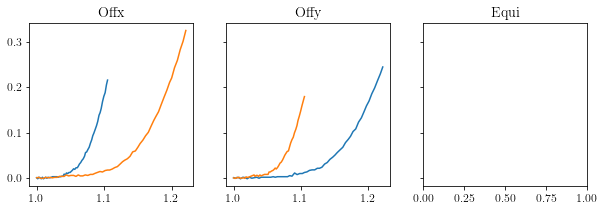

In [9]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
ax[0].plot(AX[:,0],AX[:,1])
ax[0].plot(AX[:,2],AX[:,3])
ax[0].set_title("Offx")
ax[1].plot(AY[:,0],AY[:,1])
ax[1].plot(AY[:,2],AY[:,3])
ax[1].set_title("Offy")
# ax[2].plot(AE[:,0],AE[:,1])
# ax[2].plot(AE[:,2],AE[:,3])
ax[2].set_title("Equi")
plt.show()

## Objective function for fitting 

In [10]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2/len(lam1)  
    return np.sqrt(err)/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [1,1,1,0.2,np.pi/3] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,-np.pi/2],[10.,10.,1000.,1/3,np.pi/2] ) #Bounds on parameters

### Run the optimizer and inspect the results

In [11]:
optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Optim for A ",optA.x)

Optim for A  [0.01723647 1.28295029 1.02358374 0.25282412 0.64336645]


#### Plot

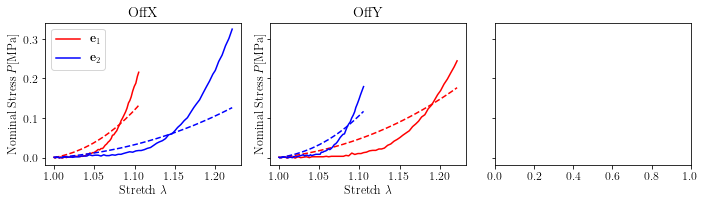

In [13]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)

lam1_1 = AX[:,0]
lam1_2 = AX[:,2]
PE1_1 = AX[:,1]
PE1_2 = AX[:,3]
Parr1 = np.zeros([len(lam1_1),2])
for i in range(0,len(lam1_1)):
        P = evalP(optA.x,lam1_1[i],lam1_2[i])
        Parr1[i,0] = P[0,0]
        Parr1[i,1] = P[1,1]

        
lam2_1 = AY[:,0]
lam2_2 = AY[:,2]
PE2_1 = AY[:,1]
PE2_2 = AY[:,3]
Parr2 = np.zeros([len(lam2_1),2])
for i in range(0,len(lam2_1)):
        P = evalP(optA.x,lam2_1[i],lam2_2[i])
        Parr2[i,0] = P[0,0]
        Parr2[i,1] = P[1,1]

# lam3_1 = AE[:,0]
# lam3_2 = AE[:,2]
# PE3_1 = AE[:,1]
# PE3_2 = AE[:,3]
# Parr3 = np.zeros([len(lam3_1),2])
# for i in range(0,len(lam3_1)):
#         P = evalP(optA.x,lam3_1[i],lam3_2[i])
#         Parr3[i,0] = P[0,0]
#         Parr3[i,1] = P[1,1]
        
ax[0].plot(lam1_1,PE1_1,color='r',label=r'$\mathbf{e}_1$')       
ax[0].plot(lam1_1,Parr1[:,0],'--',color='r')
ax[0].plot(lam1_2,PE1_2,color='b',label=r'$\mathbf{e}_2$')       
ax[0].plot(lam1_2,Parr1[:,1],'--',color='b') 
ax[0].set_title("OffX")
ax[0].set_xlabel(r'Stretch $\lambda$')
ax[0].set_ylabel(r'Nominal Stress $P$[MPa]')
ax[0].legend()

ax[1].plot(lam2_1,PE2_1,color='r',label=r'$\mathbf{e}_1$')       
ax[1].plot(lam2_1,Parr2[:,0],'--',color='r')
ax[1].plot(lam2_2,PE2_2,color='b',label=r'$\mathbf{e}_2$')       
ax[1].plot(lam2_2,Parr2[:,1],'--',color='b')  
ax[1].set_title("OffY")
ax[1].set_xlabel(r'Stretch $\lambda$')
ax[1].set_ylabel(r'Nominal Stress $P$[MPa]')


# ax[2].plot(lam3_1,PE3_1,color='r',label=r'$\mathbf{e}_1$')       
# ax[2].plot(lam3_1,Parr3[:,0],'--',color='r')
# ax[2].plot(lam3_2,PE3_2,color='b',label=r'$\mathbf{e}_2$')       
# ax[2].plot(lam3_2,Parr3[:,1],'--',color='b')  
# ax[2].set_title("Equi")
# ax[2].set_xlabel(r'Stretch $\lambda$')
# ax[2].set_ylabel(r'Nominal Stress $P$[MPa]')

plt.tight_layout()
plt.savefig("Img/"+Exp+".png",dpi=300)
plt.show()
